In [ ]:
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import numpy as np
import copy

In [ ]:
torch.manual_seed(473)
device=""
if torch.cuda.is_available():
    device=torch.device("cuda")
else:
    device=torch.device("cpu")
device

device(type='cuda')

In [ ]:
batch_size=32
#train_loader=torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)

transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
trainset=torchvision.datasets.MNIST(root=".",train=True,download=True,transform=transform)
testset=torchvision.datasets.MNIST(root=".",train=False,download=True,transform=transform)


100%|██████████| 9912422/9912422 [00:00<00:00, 83036831.66it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 4751537.37it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 27073472.19it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21120320.14it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
def dataextract(n,tset):
  itt=iter(tset)
  DATA=[]
  for i in range(len(tset)):
    K=next(itt)
    if K[1] in n:
      DATA.append((K[0],K[1]))
  return DATA

def plotter(model,dataloader,n):
  iterr=iter(dataloader)
  for i in range(n**2):
    img,lbl=next(iterr)
    with torch.no_grad():
      out=model(img[i].view(1,28*28))
    pred=torch.exp(out).numpy().argmax(axis=1)
    ax=plt.subplot(n,n,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img[i].reshape(28,28),cmap='gray')
    tit='C: '+str(lbl.numpy()[i])+"; P: "+str(pred)
    plt.title(tit)




In [ ]:
class Customdata(torch.utils.data.Dataset):
  def __init__(self,n,tset,transform=None):
    self.dat=dataextract(n,tset)
    self.transform=transform
  def __len__(self):
    return len(self.dat)
  def __getitem__(self,index):
    #if self.transform:
    #  img=self.transform(self.dat[index][0])
    return (self.dat[index][0],self.dat[index][1])

In [ ]:
class mymnist(nn.Module):
  def __init__(self,inputsize,hiddenlsize):
    super().__init__()
    self.firstlayer=nn.Linear(inputsize,hiddenlsize[0])
    self.firstactive=nn.ReLU()
    self.secondlayer=nn.Linear(hiddenlsize[0],hiddenlsize[1])
    self.secondactive=nn.ReLU()
    self.thirdlayer=nn.Linear(hiddenlsize[1],10)
    self.final=nn.LogSoftmax()



  def forward(self,x):
    out=self.firstlayer(x)
    out=self.firstactive(out)
    out=self.secondlayer(out)
    out=self.secondactive(out)
    out=self.thirdlayer(out)
    out=self.final(out)

    return out

  def trainer(self,dataloader):
    epochs=5
    lr=0.003
    momentum=0.9
    lossfunction=nn.NLLLoss()#for classifying problems with 'c' number of classes
    optimizer=torch.optim.SGD(self.parameters(),lr=lr,momentum=momentum)
    for i in range(epochs):
      runningloss=0
      for images,labels in dataloader:
        images=images.view(images.shape[0],-1)#tensor from [batchsize,1,28,28] to [batchsize,28*28] ==> flatten images

        optimizer.zero_grad()
        out=self(images)#applies model to each image in batch and return label list for the batch
        #print('a')
        #print(out.shape)
        #print(labels.shape)
        loss=lossfunction(out,labels)#each image in batch==> {out[i][0],out[i][1]...out[i][c] }==> should have class given in labels[i] i.e out[i][labels[i]] should be 1
        loss.backward()
        optimizer.step()

        runningloss += loss.item()
      print("epoch: "+str(i)+" : loss= "+str(runningloss))

  def tester(self,dataloader):
    correct,all=0,0
    for images,labels in dataloader:
      for i in range(len(labels)):
        img=images[i].view(1,28*28)
        with torch.no_grad():
          outs=self(img)
        pred=torch.exp(outs).numpy().argmax(axis=1)
        if pred== labels.numpy()[i]:
          correct +=1
        all +=1
    print("All= "+str(all)+"; correct= "+str(correct)+"; Accuracy= "+str(correct/all))

  def visulaiser(self,dataloader):
    L1his=[]
    L2his=[]
    for images, labels in dataloader:
      for i in range(len(labels)):
        img=images[i].view(1,28*28)
        with torch.no_grad():
          outs=self.firstactive(self.firstlayer(img))
          l1=outs[0].numpy()
          outs=self.secondactive(self.secondlayer(outs))
          l2=outs[0].numpy()
          outs=self.final(self.thirdlayer(outs))
          l3=np.zeros(10)
          l3[torch.exp(outs[0]).numpy().argmax(axis=0)]=1
          #print(l3)
          LAYER1=[[],[]]
          LAYER2=[[],[]]
          LAYER3=[[],[]]
          for j in range(len(l1)):
            if l1[j]>0:
              LAYER1[0].append(-1)
              LAYER1[1].append(j*2)
          for j in range(len(l2)):
            if l2[j]>0:
              LAYER2[0].append(1)
              LAYER2[1].append(j*4)
          for j in range(len(l3)):
            if l3[j]>0:
              LAYER3[0].append(2)
              LAYER3[1].append(j)
          s,al=2.5,1
          if torch.exp(outs[0]).numpy().argmax(axis=0)==labels[i]:
            #plt.scatter(LAYER1[0],LAYER1[1],color='red',s=s,alpha=al)
            #plt.scatter(LAYER2[0],LAYER2[1],color='blue',s=s,alpha=al)
            #plt.scatter(LAYER3[0],LAYER3[1],color='black',s=s,alpha=al)
            #plt.title(labels[i])
            #plt.grid(which='major')
            #plt.show()
            L1his.extend(LAYER1[1])
            L2his.extend(LAYER2[1])

    #plt.hist(L1his)
    #plt.show()
    return (L1his,L2his)

In [ ]:
CDATA={}
for i in range(9):
  CDATA[i]=None

In [ ]:

def layeranalyser(model):
  plt.rcParams.update({'font.size': 5})
  fig1, ax1 = plt.subplots(3, 3)
  fig2, ax2 = plt.subplots(3, 3)
  for i in range(9):
    if CDATA[i]==None:
      data=Customdata([i],trainset)
      CDATA[i]=copy.deepcopy(data)
    else:
      data=CDATA[i]
    print(i)
    dataloader=torch.utils.data.DataLoader(data,batch_size=4,shuffle=True)
    l1,l2=model.visulaiser(dataloader)

    ax1[int(i/3),i%3].hist(l1)
    ax1[int(i/3),i%3].set_title('(l1)'+str(i))
    ax1[int(i/3),i%3].grid(which='major')
    ax2[int(i/3),i%3].hist(l2,color='black')
    ax2[int(i/3),i%3].grid(which='major')
    ax2[int(i/3),i%3].set_title('(l2)'+str(i))
  fig1.show()
  fig2.show()

In [ ]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=4,shuffle=True)


MODEL: 0
>>>>>>>>>>>>>>>>>>>>>>>
All= 10000; correct= 1439; Accuracy= 0.1439
epoch: 0 : loss= 5197.999326767393
epoch: 1 : loss= 2868.5021179092337
epoch: 2 : loss= 2317.594192543154
epoch: 3 : loss= 1981.188336947968
epoch: 4 : loss= 1784.0675071981066
All= 10000; correct= 9607; Accuracy= 0.9607
>>>>>>>>>>>>>>>>>>>>>>>
0
1
2
3
4
5
6
7
8
>>>>>>>>>>>>>>>>>>>>>>>####################<<<<<<<<<<<<<<<<<<<<<<<<
MODEL: 1
>>>>>>>>>>>>>>>>>>>>>>>
All= 10000; correct= 984; Accuracy= 0.0984
epoch: 0 : loss= 5194.690556893138
epoch: 1 : loss= 2897.5368440313446
epoch: 2 : loss= 2333.596514072361
epoch: 3 : loss= 2012.7918826682553
epoch: 4 : loss= 1816.1998901540273
All= 10000; correct= 9548; Accuracy= 0.9548
>>>>>>>>>>>>>>>>>>>>>>>
0
1
2
3
4
5
6
7
8
>>>>>>>>>>>>>>>>>>>>>>>####################<<<<<<<<<<<<<<<<<<<<<<<<
MODEL: 2
>>>>>>>>>>>>>>>>>>>>>>>
All= 10000; correct= 766; Accuracy= 0.0766
epoch: 0 : loss= 5228.142554072792
epoch: 1 : loss= 2954.780819480762
epoch: 2 : loss= 2386.5251176275738
ep

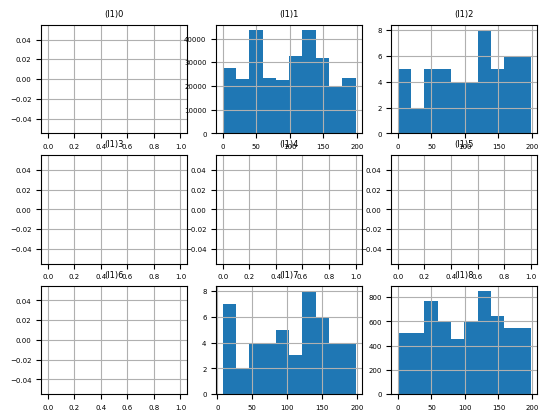

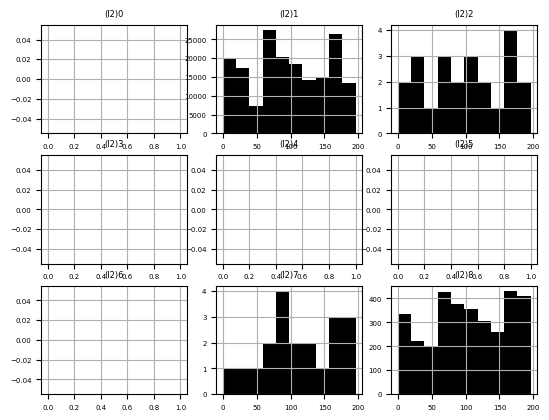

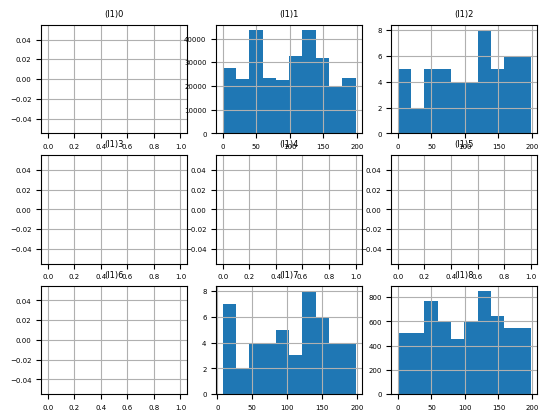

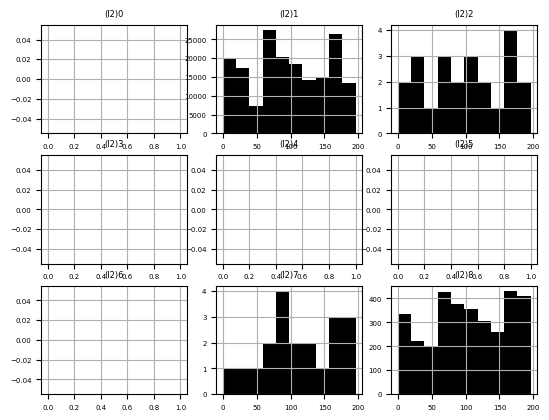

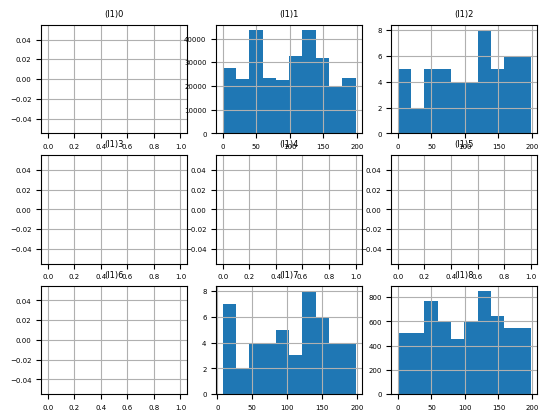

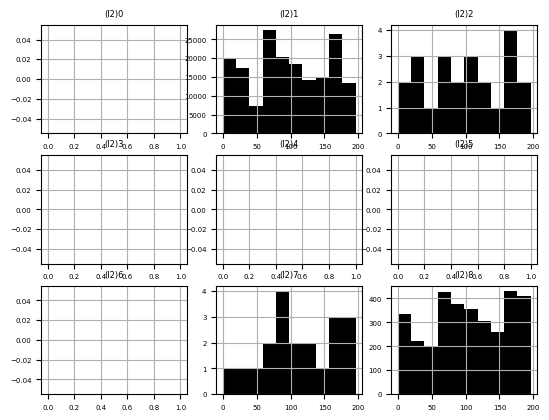

In [ ]:
M=[]
for i in range(3):
  model=mymnist(784,[100,50])
  M.append(copy.deepcopy(model))
  print("MODEL: "+str(i))
  print(">>>>>>>>>>>>>>>>>>>>>>>")
  model.tester(testloader)
  model.trainer(trainloader)
  model.tester(testloader)
  print(">>>>>>>>>>>>>>>>>>>>>>>")
  #layeranalyser(model)
  print(">>>>>>>>>>>>>>>>>>>>>>>####################<<<<<<<<<<<<<<<<<<<<<<<<")


In [ ]:
CDATA

{0: <__main__.Customdata at 0x7d23cfc17e80>,
 1: <__main__.Customdata at 0x7d23e7874d60>,
 2: <__main__.Customdata at 0x7d23cfc4dd50>,
 3: <__main__.Customdata at 0x7d23cfebfa90>,
 4: <__main__.Customdata at 0x7d23cf880790>,
 5: <__main__.Customdata at 0x7d23cd5fcca0>,
 6: <__main__.Customdata at 0x7d23cfd89ed0>,
 7: <__main__.Customdata at 0x7d23c887dff0>,
 8: <__main__.Customdata at 0x7d23cd449270>}

>>>>>>>>>>>>>>>>>>0
0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


1
2
3
4
5
6
7
8
>>>>>>>>>>>>>>>>>>1
0
1
2
3
4
5
6
7
8
>>>>>>>>>>>>>>>>>>2
0
1
2
3
4
5
6
7
8


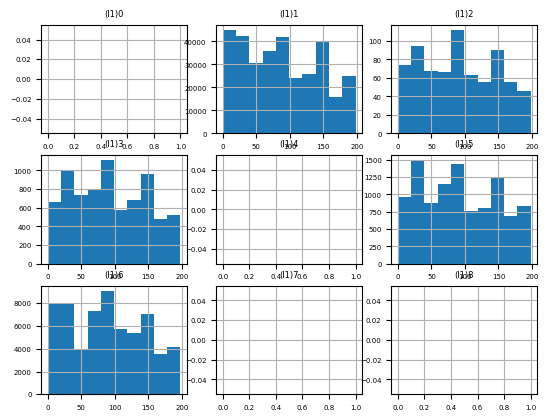

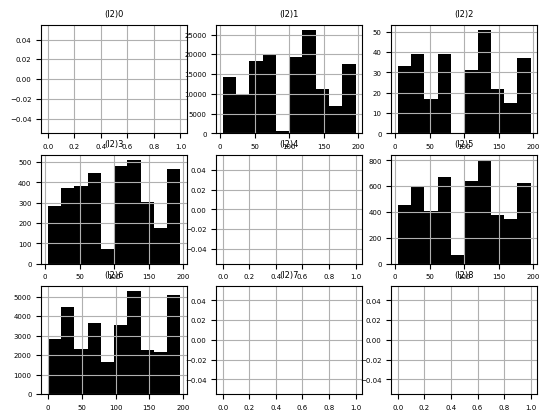

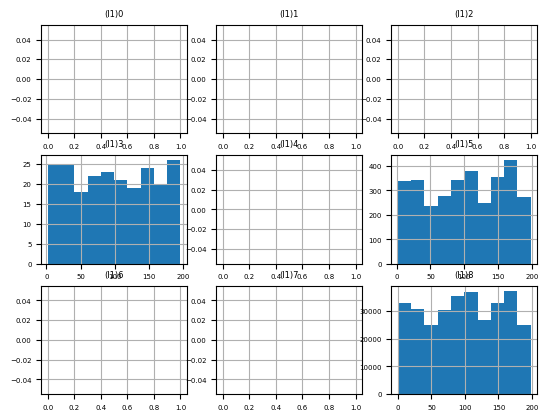

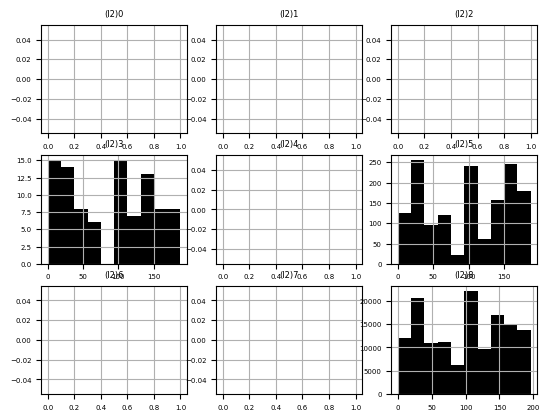

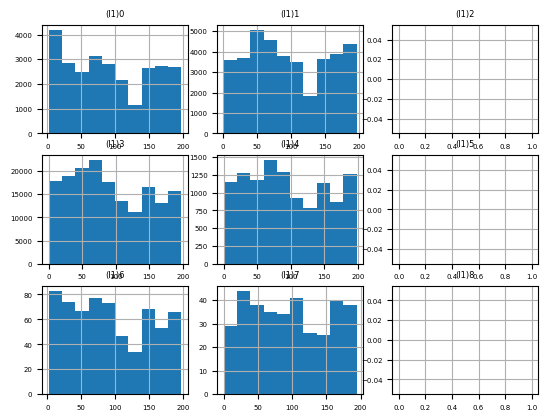

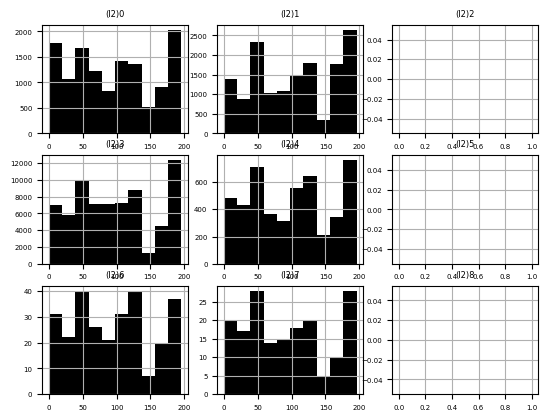

In [ ]:
i=0

for m in M:
  #print(m)
  print(">>>>>>>>>>>>>>>>>>"+str(i))
  layeranalyser(m)
  i=i+1